In [ ]:
# ==========================================
# SETUP BLOCK - loads data, applies project helpers
# ==========================================

import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# imports
sys.path.append(os.path.abspath(".."))
from Helper_funtions import (
    clean_up_subjects,
    calculate_true_false_score,
    calculate_Internet_terms_understanding_score,
    group_internet_understanding,
    analyze_distribution_changed, 
    analyze_subject_distribution_changed
)

from answer_categories import question_orders

# plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# load data 
DATA_FILE = os.path.join("..", "Data", "Fertige Tabelle.xlsx")
df = pd.read_excel(DATA_FILE)
df.columns = df.columns.str.strip()

# Clean up multi-subject columns
for col in ["Most used subjects", "Preferred Subjects", "Least preferred Subjects"]:
    if col in df.columns:
        df = clean_up_subjects(df, col)

# Calculate additional scores
if all(q in df.columns for q in ["True/False_1", "True/False_2"]):
    df = calculate_true_false_score(df)

if any(col.startswith("Internet terms_") for col in df.columns):
    df = calculate_Internet_terms_understanding_score(df)
    df = group_internet_understanding(df)

print("Setup complete – DataFrame loaded and preprocessed")
print(f"Rows: {len(df)}, Columns: {len(df.columns)}")


In [ ]:
# ------- Distribution for demographics with graphs and tables -------

def show_distribution_with_plot(df, column, title=None, color="#1f77b4", sort_values=False):
    result = analyze_distribution_changed(df, column, return_df=True)

    if result is not None:
        # sort if requested
        if sort_values:
            result = result.sort_values("Percentage", ascending=False)

        # make column label pretty (remove underscores etc.)
        pretty_col = column.replace("_", " ")
        # custom renames for clarity
        if "Educational Level parent_1" in column:
            pretty_col = "Parental education – Father / Guardian"
        elif "Educational Level parent_2" in column:
            pretty_col = "Parental education – Mother / Guardian"
        elif "CRT" in column:
            pretty_col = "CRT Score"

        ax = result.plot(
            kind="bar",
            y="Percentage",
            legend=False,
            title=title or pretty_col,
            color=color
        )
        ax.set_ylabel("Percentage", fontsize=14, fontweight="bold")
        ax.set_xlabel(pretty_col, fontsize=14, fontweight="bold")
        ax.set_title(title or pretty_col, fontsize=16, fontweight="bold")
        ax.tick_params(axis="x", rotation=45, labelsize=12, width=2)
        ax.tick_params(axis="y", labelsize=12, width=2)

        plt.tight_layout()
        plt.show()
        
        print(f"\n🔹 Table for: {title or pretty_col}")
        print(result.to_string())

# copy to avoid touching the original df
df_en = df.copy()

# mappings 
gender_map = {
    "Weiblich": "Female",
    "Männlich": "Male",
    "Keine Angabe": "No answer"
}

parent_level_map = {
    "Abschluss an einer Universität / ETH": "University / ETH",
    "Abschluss an einer Universität oder ETH": "University / ETH",
    "Abschluss an einer Hochschule / Fachhochschule": "University of applied sciences",
    "Abschluss an einer Fachhochschule / Hochschule": "University of applied sciences",
    "Berufsabschluss": "Vocational qualification",
    "Abschluss eines Doktorat / Professur": "Doctorate / Prof.",
    "Obligatorische Schule": "Mandatory school",
    "Matura": "Matura",
    "Ich weiss es nicht": "Don't know"
}

# 3) apply mappings
if "Gender" in df_en.columns:
    df_en["Gender"] = df_en["Gender"].astype(str).str.strip().replace(gender_map)

for col in ["Educational Level parent_1", "Educational Level parent_2"]:
    if col in df_en.columns:
        df_en[col] = df_en[col].astype(str).str.strip().replace(parent_level_map)

# 4) (optional) fix the order if your analyze_* functions use `question_orders`
english_parent_order = [
    "University / ETH",
    "Don't know",
    "University of applied sciences",
    "Vocational qualification",
    "Doctorate / Prof.",
    "Mandatory school",
    "Matura",
]
try:
    question_orders["Educational Level parent_1"] = english_parent_order
    question_orders["Educational Level parent_2"] = english_parent_order
except Exception:
    pass  # ok if question_orders isn’t used

# ---- Demographic Analysis (English version for some variables) ----

show_distribution_with_plot(df_en, "Gender", "Gender Distribution")
show_distribution_with_plot(df, "Age", "Age Distribution")
show_distribution_with_plot(df, "Education Level", "Students’ Education Level")
show_distribution_with_plot(df, "Hours per week for school", "Hours per Week Distribution")

show_distribution_with_plot(df_en, "Educational Level parent_1", sort_values=True)
show_distribution_with_plot(df_en, "Educational Level parent_2", sort_values=True)

show_distribution_with_plot(df, "CRT_points", "CRT Score Distribution")

# ---- Subject Preferences ----

def show_subject_distribution_with_plot(df, column, title=None):
    result = analyze_subject_distribution_changed(df, column, return_df=True)

    if result is not None:
        result.plot(kind="bar", y="Percentage of respondents", legend=False, title=title or column)
        plt.ylabel("Percentage of respondents")
        plt.xlabel(column)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
        
        print(f"\n🔹 Tabelle für: {title or column}")
        print(result.to_string())

show_subject_distribution_with_plot(df, "Preferred Subjects", "Favorite Subjects")
show_subject_distribution_with_plot(df, "Least preferred Subjects", "Least Favorite Subjects")


In [ ]:
# ------ individual graph ------

import matplotlib.pyplot as plt
import pandas as pd

# --- Counts (reale Verteilung) ---
counts = pd.DataFrame({
    "0-1 hours/week":        [3,  8,  7, 11,  4],
    "2-5 hours/week":        [5, 25, 41, 19, 17],
    "More than 5 hours/week":[3,  5, 16, 15, 14]
}, index=["Never", "Rarely", "Sometimes", "Often", "Very often"])

# Reihenfolgen festlegen
hours_order = ["0-1 hours/week", "2-5 hours/week", "More than 5 hours/week"]
freq_order  = ["Never", "Rarely", "Sometimes", "Often", "Very often"]
counts = counts[hours_order].loc[freq_order]

# Blautöne
colors = {
    "Never": "#c6dbef",
    "Rarely": "#9ecae1",
    "Sometimes": "#6baed6",
    "Often": "#3182bd",
    "Very often": "#08519c"
}

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))
bottom = pd.Series([0]*len(hours_order), index=hours_order, dtype=float)

for freq in freq_order:
    ax.bar(
        hours_order,
        counts.loc[freq, hours_order],
        bottom=bottom[hours_order],
        color=colors[freq],
        width=0.7,
        label=freq
    )
    bottom += counts.loc[freq, hours_order]

# Titel & Achsen
ax.set_title("AI usage frequency in education\nstacked by hours per week for school", fontsize=18)
ax.set_xlabel("Hours per week for school", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.tick_params(axis='both', labelsize=12)

# Legende umdrehen
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title="Frequency of use in education",
          loc="upper right", fontsize=10, title_fontsize=11)

plt.tight_layout()
plt.show()

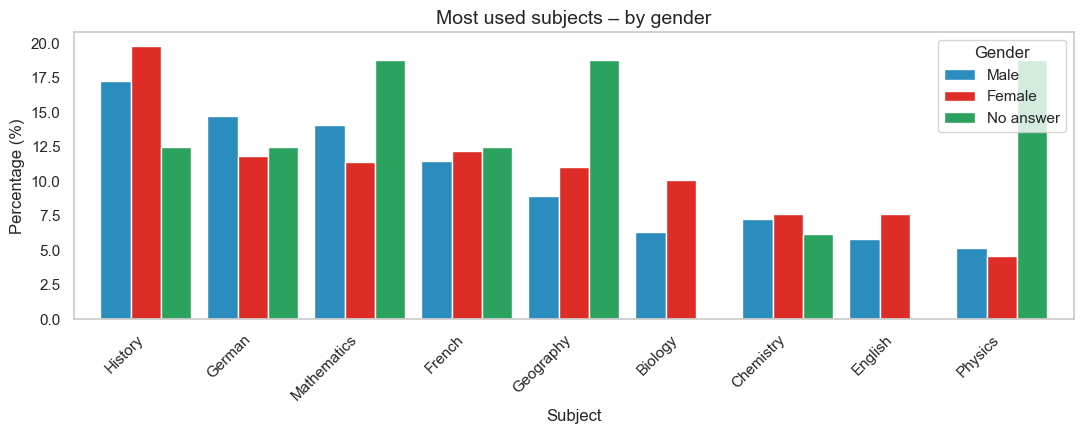

In [3]:
# ----- individual graph -----

import pandas as pd
import matplotlib.pyplot as plt

# Reihenfolge wie im Screenshot
subjects = [
    "History", "German", "Mathematics", "French", "Geography",
    "Biology", "Chemistry", "English", "Physics"
]

# Prozentwerte pro Fach (aus deiner Tabelle "Percent")
data = {
    "Male":   [17.3, 14.7, 14.1, 11.5,  8.9,  6.3,  7.3,  5.8,  5.2],
    "Female": [19.8, 11.8, 11.4, 12.2, 11.0, 10.1,  7.6,  7.6,  4.6],
    "No answer": [12.5, 12.5, 18.8, 12.5, 18.8, 0.0, 6.2, 0.0, 18.8],
}

df = pd.DataFrame(data, index=subjects)

# Plot: drei Balken pro Fach (vertikal)
ax = df.plot(
    kind="bar",
    figsize=(11, 4.5),
    width=0.85,
    color=["#2b8cbe", "#de2d26", "#2ca25f"]  # Male=blau, Female=rot, No answer=grün
)

ax.set_title("Most used subjects – by gender", fontsize=14)
ax.set_ylabel("Percentage (%)", fontsize=12)
ax.set_xlabel("Subject", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=11)
plt.yticks(fontsize=11)
plt.grid(False)
ax.legend(title="Gender", loc="upper right")

plt.tight_layout()
plt.show()